In [ ]:
#Importing python libraries
import pandas as pd
import numpy as np

#Importing Sci-kit libraries for data-preprocessing(word embedding)
import re
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report,accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings(action = 'ignore')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Installing Bloom Filter packages and Tensorflow hub  
%pip install bloom_filter
%pip install tensorflow_hub

#Importing tensorflow-keras libraries 
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from bloom_filter import BloomFilter

In [ ]:
#Reading contents of the malicious and non-malicious urls from the file.
Traindata_df = pd.read_csv("/content/malicious_phish.csv")
X=Traindata_df['url']
Y=Traindata_df['type']
Y_new=[]
count1=0
count2=0

#label encoding the benign type urls as 0 and phishing type as 1.
for row in Y:
    if row=='benign':
       row=0
       count1+=1
    else:
       row=1
       count2+=1
    Y_new.append(row)

#printing the total number of records and malicious and non-malicious urls.
print("total records:",len(Y_new))
print("non-maliciuos urls(labeled as 0):", count1)
print("malicious urls(labeled as 1):",count2)

total records: 651191
non-maliciuos urls(labeled as 0): 428103
malicious urls(labeled as 1): 223088


**Word Embedding**

In [ ]:
data=[]
for row in X:
	row=sent_tokenize(row)
	#print(row)
	temp = []
	# tokenize the sentence into words
	for j in word_tokenize(str(row[0])):
		temp.append(j.lower())
		
	#print(temp)
	data.append(temp)

In [ ]:
# CBOW model
model = gensim.models.Word2Vec(data, min_count = 1,
							size = 100, window = 5)

In [ ]:
#Integer Encoding 
vocab_size = len(model.wv.vocab)
encoded_docs = [one_hot(d, vocab_size) for d in X]
print(encoded_docs[0])
#print(encoded_docs[0])


[192094, 500091, 275516, 192094]


In [ ]:
# padding documents to a max length of 4 words
max_length = len(max(encoded_docs, key=len))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
#print(padded_docs)

**FIRST APPROACH**

In [ ]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
#adding convolution layer
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
#adding pooling layer
model.add(MaxPooling1D(pool_size=2))
#adding fully connected layer
model.add(Flatten())
model.add(Dense(10, activation='relu'))
#adding output layer
model.add(Dense(1, activation='sigmoid'))
# compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarizing the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 368, 8)            5329440   
                                                                 
 conv1d (Conv1D)             (None, 361, 32)           2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 180, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5760)              0         
                                                                 
 dense (Dense)               (None, 10)                57610     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

In [ ]:
#Splitting the data into train and testing data.
import numpy as np
Y=np.array(Y_new)
X_train, X_test, Y_train, Y_test = train_test_split(padded_docs, Y, test_size=0.3, random_state=42)

In [ ]:
#fitting the model
model.fit(X_train, Y_train, epochs=1, verbose=0)

In [ ]:
# evaluation of the model
loss_tr, accuracy_tr = model.evaluate(X_train, Y_train, verbose=0)
loss_tst, accuracy_tst =model.evaluate(X_test,Y_test)
print('loss train:',loss_tr,'Accuracy train: %f' % (accuracy_tr*100))
print('loss test:',loss_tst,'Accuracy test: %f' % (accuracy_tst*100))

6105/6105 [==============================] - 15s 2ms/step - loss: 0.0894 - accuracy: 0.9646
loss train: 0.05862855166196823 Accuracy train: 97.467494
loss test: 0.08938349783420563 Accuracy test: 96.463418


In [ ]:
 #overFlow Bloom Filter 
 def Train_overflow(bloom,train_features, train_labels,preds,tau):
      
    X_train=train_features
    y_train=train_labels
    for i in range(len(preds)):
        if preds[i]<tau:
              if y_train[i] ==1:
                  bloom.add(str(X_train[i]))
    return bloom

In [ ]:
#setting an Threshold value 
tau=0.9
#creating traditional bloom filter for overflow
bloom_traditional = BloomFilter(max_elements=325000)
#model predictions
preds= model.predict(X_train)
#checking the predicted records existence in overflow bloom filter
bloom_overflow=Train_overflow(bloom_traditional,X_train,Y_train,preds,tau)

In [ ]:
#defining the Function and partitioning into keys and Non-keys
def malicious_new(X,Y,tau,predicted_tst):
    keys=[]
    non_keys=[]
    pred_keys=[]
    pred_non_keys=[]
    actual_for_keys=[]
    actual_for_non_keys=[]
    #print("positive",len(Y))
    count1=0
    count2=0
    for i in range(len(predicted_tst)):
     if predicted_tst[i]>tau :
        keys.append(X[i])
        pred_keys.append(1)
        if predicted_tst[i]!=Y[i]:
           count1+=1
           #print(count1)
     elif str(X[i]) in bloom_overflow:
           keys.append(X[i])
           count2+=1
     else:
          non_keys.append(X[i])
          pred_non_keys.append(0)
           #print(count2)
    return keys,non_keys,pred_keys,pred_non_keys,actual_for_keys,actual_for_non_keys,count1,count2

In [ ]:
#initializing the latency metrics
latency_plt=[]
FPR=[]

In [ ]:
batch=[40000,80000,120000,160000,]
X_test1=X_test[:40000]
len(X_test1)

40000

In [ ]:
prediction_tst=model.predict(X_test1)

In [ ]:
import time

In [ ]:
#starting the timer
start_time=time.time()

#classifying the keys and non-keys based upon threshold
y=[]
for i in range(len(prediction_tst)):
        if(prediction_tst[i]> 0.9):
          y.append(1)
        else:
          y.append(0)

tau=0.9
keys,non_keys,pred_keys,pred_nonkeys,actual_for_keys,actual_for_non_keys,count1,count2=malicious_new(X_test1,Y_test,tau,y)
keys=np.array(keys)

#stopping the timer
stop_time=time.time()-60
res_time=stop_time-start_time
latency_plt.append(res_time)

In [ ]:
#calculating the False postive and False negative rate 
print("FPR",count1/len(non_keys),"FNR",count2/len(keys))

FPR 0.0020429230402737373 FNR 0.001249318153824497


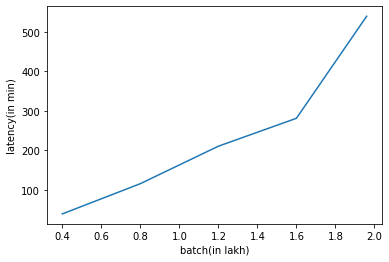

In [ ]:
#Plotting the grapgh for latency 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

batch1=[0.4,0.8,1.2,1.6,1.96]

# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# naming the x axis
plt2.xlabel('batch(in lakh)')
# naming the y axis
plt2.ylabel('latency(in min)')
plt2.plot(batch1,latency_plt)
#plt2.plot(memory_plt)

**SECOND APPROACH**


In [ ]:
#Installing the piece-wise linear regression model packages
%pip install pwlf
!pip install mlinsights

  Created wheel for pwlf: filename=pwlf-2.2.1-py3-none-any.whl size=16609 sha256=79695ae03288b566da86caa5c25103aa6b2f94377a924c22c69ce4497aa9aea8
  Stored in directory: /root/.cache/pip/wheels/2d/71/b9/a5f72e5ebcb7538f085c07fc6ab888057508655fe4c161cce9
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=c5d1f98afb700aa426a1173eb1c5201bd869cc5321e40b3c193f7eeae9101d51
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pwlf pyDOE
     |████████████████████████████████| 2.3 MB 8.3 MB/s 
     |████████████████████████████████| 126 kB 75.3 MB/s 


In [ ]:
#defining the function for partitioning into keys and Non-keys
def malicious(X,Y):
    keys=[]
    nonkeys=[]
    pred_nonkeys=[]
    print("malicious",len(Y))
    for i in range(len(Y)):
       if(Y[i]== 1):
         keys.append(X[i])
       else:
         nonkeys.append(X[i])
         pred_nonkeys.append(Y[i])
         #print(keys,X[i])
    return keys,nonkeys,pred_nonkeys

#defining the hash function for computing the index
def hashfunc(y_pred, m):
    d=np.floor(y_pred*m).astype(int)
    return d
#defining the bitmap array for marking the computed indicies(keys) as 1
def bitmap(y_pred,m):
    M=[]
    M=[0]*m
    d=hashfunc(y_pred,m)
    for i in d:
       #print(i)
       M[i]=1
    return M

In [ ]:
#importing the libraries for piecewiseregressor model
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.preprocessing import KBinsDiscretizer 
model = PiecewiseRegressor(verbose=True,
                           binner=KBinsDiscretizer(n_bins=3))

#fitting the data to the model
model.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10019 out of 10019 | elapsed:   41.8s finished


PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=3),
                   estimator=LinearRegression(), verbose=True)

In [ ]:
#segragating keys and non-keys
keys,non_keys,pred_nonkeys=malicious(X_train,Y_train)
keys=np.array(keys)
# model predictions for keys. 
prediction_tr =  model.predict(keys)
#normlaizing the predicted data to be in range(0-1)
for i in range(len(prediction_tr)):
    if prediction_tr[i] >=1:
      prediction_tr[i]=0.99
    elif prediction_tr[i] <0:
      prediction_tr[i]=0.01

[0.98050373 0.56079863 0.32801385 ... 0.76472783 0.24812606 0.99780036] 1.8080049378375027 -0.6953125


In [ ]:
#calling function to create bitmap array for the training data
m=325000
M=bitmap(prediction_tr, m)

In [ ]:
#initializing the latency metrics array
latency_plt=[]

In [ ]:
#seperating into batches
batch=[40000,80000,120000,160000,196000]
X_test1=X_test[0:196000]
len(X_test1)

malicious 160000


In [ ]:
#starting the timer
start_time=time.time()
#predicting for the test data
prediction_lr_test=model.predict(X_test1)
keys,non_keys,pred_nonkeys=malicious(X_test,prediction_lr_test)
#normalising the predicted data
for i in range(len(pred_nonkeys)):
    if pred_nonkeys[i] >=1:
      pred_nonkeys[i]=0.99
    elif pred_nonkeys[i] < 0:
      pred_nonkeys[i]=0.01
#computing the indicies for the test data using hash function for the records predicted as keys
c=[]
for i in range(len(pred_nonkeys)):
    c.append(np.floor(pred_nonkeys[i]*m).astype(int))

#calculating the false positive rate. 
sum=0
for i in c:
  sum+=M[i]
print(sum)
print("FPR rate:", sum/len(pred_nonkeys))

#stopping the timer
stop_time=time.time()
start_mem =5.55
res_time=stop_time-start_time

#memory_plt.append(res_mem)
latency_plt.append(res_time)


malicious 160000


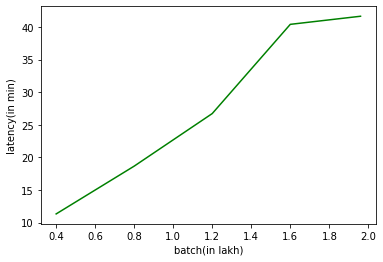

In [ ]:
import matplotlib.pyplot as plt2
batch1=[0.4,0.8,1.2,1.6,1.96]

# naming the x axis
plt2.xlabel('x - axis')
# naming the y axis
plt2.ylabel('y - axis')
# naming the x axis
plt2.xlabel('batch(in lakh)')
# naming the y axis
plt2.ylabel('latency(in min)')
plt2.plot(batch1,latency_plt,color='green')



**TRADITIONAL BLOOM FILTER**

In [ ]:
#defining function for testing the bloom filter
def Testing_BF(bloom1, test_data):
  y_pred_bloom = []
  for i in test_data:
    if str(i) in bloom1:
      y_pred_bloom.append(1)
    else:
      y_pred_bloom.append(0)
  y_pred_bloom = np.array(y_pred_bloom)
  return y_pred_bloom

In [ ]:
#creating traditional bloom filter
bloom4 =BloomFilter(max_elements=325000)
dataset=[]
for i in range(len(X)):
   dataset.append([X[i],Y[i]])
#adding the malicious urls for the taken dataset.   
for data_point in dataset:
        if data_point[1]==1:
            bloom4.add(data_point[0])

In [ ]:
#predictions for the training dataset(insert)
y_pred_bloom_tr=Testing_BF(bloom4,X_train_BF)


In [ ]:
print(accuracy_score(y_pred_bloom_tr,Y_train_BF))

0.977153913823703


In [ ]:
#initlialising the latency metrics 
latency_plt=[]

In [ ]:
#initilaising the batch metrics
batch=[40000,80000,120000,160000,196000]

X_test1=X_test_BF[:196000]
len(X_test1)

195358

In [ ]:
#starting the timer
start_time=time.time()
#predictions for  the test data(LookUp)
y_pred_bloom=Testing_BF(bloom4, X_test1)
#stopping the timer.
stop_time=time.time()
res_time=stop_time-start_time
#appending to the list of latency
latency_plt.append(res_time)

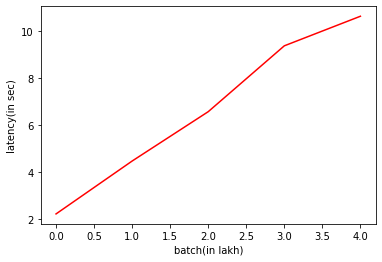

In [ ]:
plt2.xlabel('batch(in lakh)')
# naming the y axis
plt2.ylabel('latency(in sec)')
plt2.plot(latency_plt, label='Traditional', color='red')

In [ ]:
#Calculating true negatives
TN=0
for i in range(len(Y_test)):
  if Y_test[i] == 0:
       TN+=1
print("TN",TN)

#Calculating true positives
TP=0
for i in range(len(Y_test)):
  if Y_test[i] == 1:
       TP+=1
print("TP",TP)

TN 128733
TP 66625


In [ ]:
#Defining False positive for Traditional Bloom filter 
def Test_FPR_bloom(prediction,Y_test):
      output1=[]
      count1=0
      for i in range(len(X_test)):
             if(Y_test[i]==0 and prediction[i]==1):
               count1+=1
      
      return count1

In [ ]:
#Defining the False negative for Traditional Bloom Filter 
def Test_FNR_bloom(y_pred_bloom,Y_test):
    count1=0
    for i in range(len(Y_test)):
          if Y_test[i] == 1 and y_pred_bloom[i]==0:
             count1+=1

    if count1==TN:
        return 0
    else:
        return TN-count1

In [ ]:
#Calculating False positive and false Negative 
FN=Test_FNR_bloom(y_pred_bloom,Y_test)
if(FN==0):
  print("zero false negative rate")
else:
  print(FN,FN/(FN+TP))
FP=Test_FPR_bloom(y_pred_bloom,Y_test)
print(FP,FP/(FP+TN))

97295 0.5935517325524646
68114 0.34602508547247357
